# Figure 8

In [1]:
# Import necessary libraries
from __future__ import division, print_function, unicode_literals

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.usetex'] = False

import tensorflow as tf
import numpy as np
from functools import partial
import glob, os
import pickle
import copy
from PDEsolvers import HeatEqn_FT

In [2]:
# User inputs
data_name = 'Heat_Eqn_exp29'  # Prefix of data files
folder_name = 'Heat_exp29c/'  # Folder to be created for saved output

In [3]:
# Find the model with lowest validation error
import math

def BestErrorFile(folder_name):

    filename_best = ''
    best_error = 10**6

    current_dir = os.getcwd()
    os.chdir("./" + folder_name)
    for file in glob.glob("*.pkl"):
        with open(file, 'rb') as f:
            params = pickle.load(f)
            if not math.isnan(params['minRegTest']):
                if params['minRegTest'] < best_error:
                    filename_best = file
                    best_error = params['minRegTest']
    os.chdir(current_dir)

    return filename_best

pkl_file = folder_name + BestErrorFile(folder_name)

with open(pkl_file, 'rb') as f:
     params = pickle.load(f)

params['model_restore_path'] = params['model_path']
print(pkl_file)
print(params['minTest'])
print(params['minTrain'])

Heat_exp29c/Heat_Eqn_exp29_2019_08_04_05_22_13_599012_model.pkl
0.0710781492292881
0.06387144327163696


In [4]:
# Get all the needed things from the network

tf.reset_default_graph()

with tf.Session() as sess:
    saver = tf.train.import_meta_graph(params['model_path']+'.meta')
    saver.restore(sess, params['model_path'])
    
    L_mat = sess.run(tf.get_default_graph().get_tensor_by_name("dynamics/L:0"))
    FT = sess.run(tf.get_default_graph().get_tensor_by_name("encoder/FT:0"))

INFO:tensorflow:Restoring parameters from ./Heat_exp29c/Heat_Eqn_exp29_2019_08_04_05_22_13_599012_model.ckpt


In [5]:
# Calculate eigenvalues and eigenvectors
lam, V = np.linalg.eig(L_mat)
lam = np.log(lam)
ind = np.argsort(lam)
ind = np.flip(ind,0)
lam = np.sort(lam)
lam = np.flip(lam,0)
network_lam = lam/params['delta_t']
print(lam/params['delta_t'])

[ 2.8610129e-03 -1.0000083e+00 -1.0012273e+00 -4.0001421e+00
 -4.0069337e+00 -9.0014553e+00 -9.0015297e+00 -1.6016428e+01
 -1.6016998e+01 -2.4997129e+01 -2.5010124e+01 -3.5992432e+01
 -3.5995045e+01 -4.8951012e+01 -4.9028839e+01 -6.3908646e+01
 -6.4093338e+01 -8.0977509e+01 -8.1173203e+01 -1.0002786e+02
 -1.0004730e+02]


/anaconda3/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  app.launch_new_instance()
/anaconda3/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part


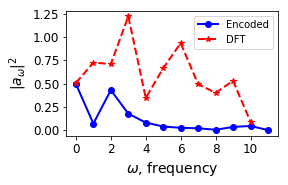

In [6]:
# Plot encoded vs fft

np.random.seed(0)  
# Create white noise
n = 128
ut = np.zeros(n, dtype=np.complex64)
ut[0] = np.random.normal()
ut[1:n//2] = np.random.normal(size=(n//2-1))+1j*np.random.normal(size=(n//2-1))
ut[n//2] = np.random.normal()
ut[n//2+1:] = np.flipud(np.conj(ut[1:n//2]))
u = np.fft.ifft(ut)

v = u.dot(FT)
v_sorted = v[ind]
combined = np.zeros((12))
combined[0] = v_sorted[0]
for k in range(10):
    combined[k+1] = np.sqrt(v_sorted[2*k+1]**2+v_sorted[2*k+2]**2)

u_hat = np.fft.fft(u, n=21)
trunc_fft = np.absolute(u_hat[:11])

plt.figure(figsize=(4,2.67))
enc, = plt.plot(combined,'o-b',linewidth=2.0)
dft, = plt.plot(trunc_fft,'*--r',linewidth=2.0)
plt.xlabel('$\omega$, frequency')
plt.ylabel('$|a_{\omega}|^2$')
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.legend([enc,dft],['Encoded','DFT'],fontsize=10)
plt.tight_layout()
plt.show()